In [73]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import nltk
from nltk.corpus import stopwords
from gensim.models import word2vec
from tensorflow.keras.models import Sequential
import re
import numpy as np
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [74]:
keras.preprocessing.text.Tokenizer(num_words=None,
                                   filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',
                                   lower=True,
                                   split=" ",
                                   char_level=False)
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>', num_words=None)  # 构造分词器

In [4]:
pip install --user gensim

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/, https://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 24.1 MB 7.6 kB/s eta 0:00:01    |██                              | 1.5 MB 359 kB/s eta 0:01:03
     |████████████████████████████████| 58 kB 707 kB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [75]:
training_set = pd.read_csv('/root/text_classification/second_train.csv')
train_text = training_set['text']
train_text_list = []  # 文本的列表形式
#nltk.download('stopwords')  # 下载停用词表
StopWords = stopwords.words('english')  # 停用词表

for i in range(len(train_text)):  # 将训练集文本转为列表形式存储
    train_text_list.append(train_text[i])

In [76]:
test_data = pd.read_csv('/root/text_classification/test.csv')
test_text = test_data['text']
test_text_list = [i for i in test_text]
print(len(test_text_list))

20001


In [77]:
# 提取标签并转成one_hot矩阵
train_label = training_set['label']
train_label_list = [i for i in train_label]
train_label_one_hot = np.eye(5)[train_label_list]
print(train_label_one_hot)

[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [78]:
def text_normalization(text_list):
    """
    文本清洗
    """
    corpus = []  # 语料
    for sentence in text_list:
        sentence = sentence.lower()  # 全部转为小写
        sentence = re.sub(r'[^a-zA-Z0-9]', " ", sentence)  # 把字母及数字之外的字符用空格代替
        # 去除url
        result = re.compile(r'http://[a-zA-Z0-9.?/&=:]*',re.S)
        sentence = result.sub("",sentence)
        # 分词与去停用词
        words = sentence.split()
        for word in words:
            if word in StopWords:
                words.remove(word)
        corpus.append(words)
    return corpus 

In [79]:
train_corpus = text_normalization(train_text_list)  # 将句子分词，形成[['a','b'],['c']]形式的语料
print(len(train_corpus))
test_corpus = text_normalization(test_text_list)
print(len(test_corpus))

8001
20001


In [9]:
total_corpus = train_corpus + test_corpus
print(len(total_corpus))

28002


In [115]:
# word2vec参数
vector_size = 100  # 向量维度
min_word_frequency = 3  # 词出现的次数不能少于3次
window_size = 4  # 上下文窗口大小
num_core = 4  # cpu工作的核心数
# word2vec模型
embedding_model = word2vec.Word2Vec(total_corpus, workers=num_core, vector_size=vector_size, window=window_size,
                                    min_count=min_word_frequency)
#embedding_model.init_sims(replace=True)  # 只保留按行归一化的向量，节省内存
embedding_model.save("yelp_W2V_model")  
print(embedding_model)

Word2Vec(vocab=21600, vector_size=100, alpha=0.025)


In [81]:
tokenizer.fit_on_texts(total_corpus)  # 载入训练文本
total_vocab = tokenizer.word_index  # 训练集词表
print(total_vocab)    

{'<UNK>': 1, 'the': 2, 'a': 3, 'i': 4, 'was': 5, 'it': 6, 'food': 7, 'good': 8, 'place': 9, 't': 10, 'my': 11, 'you': 12, 'to': 13, 'like': 14, 'is': 15, 'get': 16, 'have': 17, 'one': 18, 'not': 19, 'they': 20, 'time': 21, 'would': 22, 'we': 23, 'this': 24, 'had': 25, 'service': 26, 'great': 27, 's': 28, 'go': 29, 'that': 30, 'back': 31, 'and': 32, 'really': 33, 'be': 34, 'were': 35, 'us': 36, 'even': 37, 'got': 38, 'in': 39, 'for': 40, 'all': 41, 'of': 42, 'also': 43, 'just': 44, 'nice': 45, 'are': 46, 'very': 47, 'room': 48, 'people': 49, 'our': 50, 'much': 51, 'never': 52, 'could': 53, 'there': 54, 'well': 55, 'pretty': 56, 'little': 57, 'went': 58, 'ordered': 59, 'came': 60, 've': 61, 'first': 62, 'so': 63, 'can': 64, 'restaurant': 65, 'better': 66, 'vegas': 67, 'order': 68, 'their': 69, 'know': 70, 'best': 71, '2': 72, 'always': 73, 'said': 74, 'night': 75, 'm': 76, 'going': 77, 'way': 78, 'an': 79, 'think': 80, 'two': 81, 'come': 82, 'bad': 83, 'will': 84, 'chicken': 85, 'on': 86

In [82]:
train_textID = tokenizer.texts_to_sequences(train_corpus)  # 将每段文本转成词表里对应的数字
train_sequence_padding = pad_sequences(train_textID, 100)  # 规定最大长度为100，不够就往前面补0
print(train_sequence_padding.shape)

(8001, 100)


In [83]:
test_textID = tokenizer.texts_to_sequences(test_corpus)  # 将每段文本转成词表里对应的数字
test_sequence_padding = pad_sequences(test_textID, 100)  # 规定最大长度为100，不够就往前面补0
print(test_sequence_padding.shape)

(20001, 100)


In [84]:
total_sequence_padding = np.vstack((test_sequence_padding,train_sequence_padding))
print(total_sequence_padding.shape)

(28002, 100)


In [85]:
# 创建embedding矩阵，每行为训练好的word2vec模型中与词典编号对应的词的向量（从第1行开始）
embedding_matrix = np.zeros((len(total_vocab)+1, vector_size))
for word, i in total_vocab.items():
    try:
        vector = embedding_model.wv[word]  # 在模型中提取词典中词的向量，若没有，则会报错KeyError
        embedding_matrix[i] = vector
    except KeyError:
        continue
print(embedding_matrix.shape)    

(51374, 100)


In [21]:
pip install numpy==1.19.5  # 之前的版本过高，与tensorflow有冲突

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/, https://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 14.8 MB 884 kB/s eta 0:00:01     |████████████▌                   | 5.8 MB 22.2 MB/s eta 0:00:01     |███████████████▊                | 7.3 MB 1.5 MB/s eta 0:00:06     |█████████████████               | 7.9 MB 1.5 MB/s eta 0:00:05
ERROR: paddlepaddle-gpu 1.8.2.post107 has requirement gast>=0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: paddlepaddle-gpu 1.8.2.post107 has requirement scipy<=1.3.1; python_version >= "3.5", but you'll have scipy 1.4.1 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [101]:
# 搭建神经网络
sub_embedding = Embedding(len(embedding_matrix), vector_size, weights=[embedding_matrix], trainable=False) # 不在训练的过程中更新词向量
lstm_model = Sequential()
lstm_model.add(sub_embedding)  

lstm_model.add(LSTM(40, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(30, activation='relu'))
lstm_model.add(Dense(5, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 100)         5137400   
_________________________________________________________________
lstm_16 (LSTM)               (None, 40)                22560     
_________________________________________________________________
dense_37 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 155       
Total params: 5,161,345
Trainable params: 23,945
Non-trainable params: 5,137,400
_________________________________________________________________
None


In [102]:
# 训练模型
early_stop = EarlyStopping(monitor='val_accuracy', patience=4, mode='max')
yelp_lstm = lstm_model.fit(train_sequence_padding, train_label_one_hot, batch_size=100, epochs=100,
                        validation_split=0.2)  # , callbacks=[early_stop]

Train on 6400 samples, validate on 1601 samples
Epoch 1/100
6400/6400 [==============================] - 10s 2ms/sample - loss: 1.5601 - accuracy: 0.2794 - val_loss: 1.4900 - val_accuracy: 0.3161
Epoch 2/100
6400/6400 [==============================] - 8s 1ms/sample - loss: 1.4449 - accuracy: 0.3587 - val_loss: 1.4204 - val_accuracy: 0.3360
Epoch 3/100
6400/6400 [==============================] - 8s 1ms/sample - loss: 1.3827 - accuracy: 0.3919 - val_loss: 1.3577 - val_accuracy: 0.3685
Epoch 4/100
6400/6400 [==============================] - 8s 1ms/sample - loss: 1.3547 - accuracy: 0.4013 - val_loss: 1.3344 - val_accuracy: 0.3735
Epoch 5/100
6400/6400 [==============================] - 8s 1ms/sample - loss: 1.3280 - accuracy: 0.4170 - val_loss: 1.2947 - val_accuracy: 0.4116
Epoch 6/100
6400/6400 [==============================] - 8s 1ms/sample - loss: 1.3020 - accuracy: 0.4322 - val_loss: 1.2703 - val_accuracy: 0.4235
Epoch 7/100
6400/6400 [==============================] - 8s 1ms/sampl

In [103]:
ave = 0
num = 0
for i in yelp_lstm.history['val_accuracy']:
    if i > 0.46:
        ave += i
        num +=1
ave = ave / num        
print(ave)

0.4909695521206923


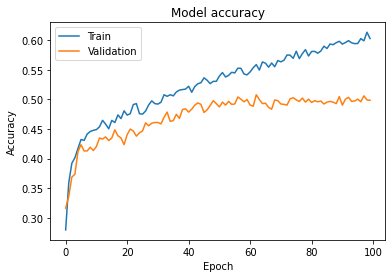

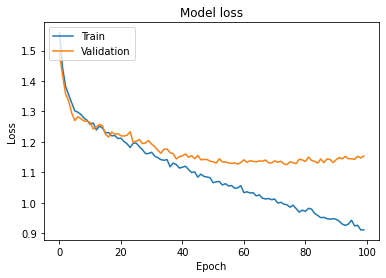

In [107]:
plt.plot(yelp_lstm.history['accuracy'])
plt.plot(yelp_lstm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('acc')
plt.show()

plt.plot(yelp_lstm.history['loss'])
plt.plot(yelp_lstm.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss')
plt.show()

In [109]:
pip install seaborn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/, https://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 292 kB 1.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [111]:
pip install sklearn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/, https://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 24.8 MB 5.2 MB/s eta 0:00:01     |██████████████                  | 10.9 MB 819 kB/s eta 0:00:18
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=1048dcaac20bdb598d9a184a0b98e769fc07ab77635345599bd18a36c4390ead
  Stored in directory: /root/.cache/pip/wheels/fd/ab/fb/a008fc45aa0b0e83bafb083e5e010f94cd11d988befec978af
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


Text(0.5, 51.0, 'prediction')

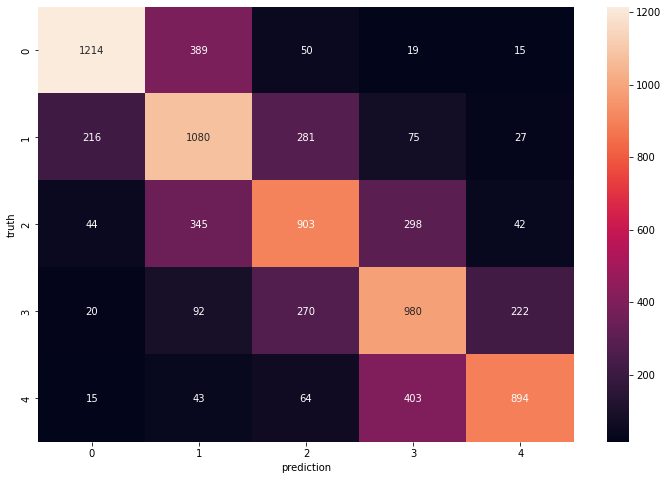

In [114]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
trained_model = lstm_model

train_pred = trained_model.predict(train_sequence_padding)
train_pred = np.argmax(train_pred, axis=1)
train_truth = train_label_list
 
#生成混淆矩阵
confuse_matrix = confusion_matrix(train_truth, train_pred)
fig, ax = plt.subplots(figsize=(12,8))
# 画图
sns.heatmap(confuse_matrix, annot=True, fmt='d',xticklabels=[i for i in range(5)], yticklabels=[i for i in range(5)])
plt.ylabel('truth')
plt.xlabel('prediction')

In [92]:
#trained_model = keras.models.load_model('yelp_cnn')
test_predict = lstm_model.predict(test_sequence_padding)
test_predict = np.argmax(test_predict, axis=1)
print(test_predict)

[0 0 0 ... 0 0 3]


In [93]:
pd.DataFrame(test_predict).to_csv('prediction.csv')